<h1>EFR teleswitch</h1>


# Introduction

Europäische Funk-Rundsteuerung (EFR) Teleswitch (European Radio Ripple Control GmbH (ERA) Teleswitch) is an energy management system operated via long-wave radio. The system is deployed by European Radio Ripple Control GmbH.
Uses two transmitters in Germany and one in Hungary, covering most of Central Europe. Also known by DCF39, DCF49 and HGA22, the transmitters in the network.<br>
EFR uses FSK modulation with 340 Hz shift at 200 bps ASCII <br>
<br>
Due to the low speed and simple modulation, EFR is a good candidate for the first exercise to learn signal-processing with python<br>
<br>
More info about EFR teleswith can be found here: <A HREF="https://www.sigidwiki.com/wiki/EFR_Teleswitch">sigidwiki</A>

## Part 1: Preparations
### Loading libraries

In [1]:
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Loading data
Note:<br>
the datafile is a recording of the three EFR transmitters, containing iq sample-data. The recording was done with gqrx in "raw-iq" receiver-mode, a SDRplay RSD-dx and an active miniwhip antenna. Using linux pulseaudio, the audio of gqrx was the piped into a GNU Radio flowgraph that converted the audio into a file of i/q data in float32 format.<br>
The sample-rate is 48 Ksamples/second.

In [2]:
samp_rate=48000.0
numsec=30 #well just oad 30 seconds of data

d=np.fromfile("efr_teleswitch_30s.f32",dtype=np.complex64,offset=0,count=int(samp_rate*numsec))


### Examining the data
Let's make a spectrogram (horizontal waterfall)<br>
<br>
Note: "plt.axis.specgram" seems to produce a much better result then scipy.signal.spectrogram

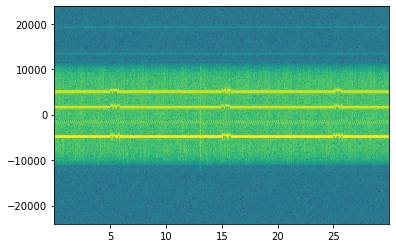

In [3]:
ax = plt.axes()
ax.specgram(d, Fs=48000, scale='dB')
plt.show()

## Part 2: Filtering out the wanted signal

Let's focus on the lowest signal (DCF49 @ 139.0 KHz). Let's zoom into the spectrumgram to determine the frequency relative to 0 Hz in the iq-sample file.

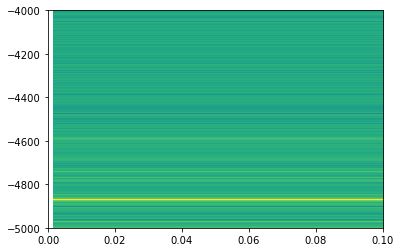

In [4]:
ax = plt.axes()
ax.specgram(d, Fs=48000, NFFT=32768,scale='dB') # note: increase the number of FFT bins to increase frequency resolution
ax.set_xlim(0,0.1)
ax.set_ylim(-5000,-4000)
plt.show()

Play with the "NFFT" and the "ax.set_ylim" values a bit more to get an exact as possible value of the frequency

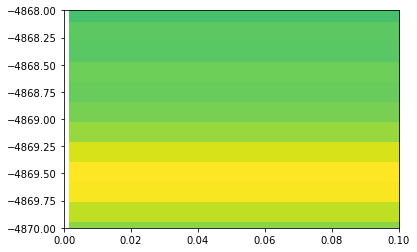

In [5]:
ax = plt.axes()
ax.specgram(d, Fs=48000, NFFT=262144,scale='dB') # note: increase the number of FFT bins to increase frequency resolution
ax.set_xlim(0,0.1)
ax.set_ylim(-4870,-4868)
plt.show()

### Automate things
OK, so the frequency seems to be around -4869.6 Hz.<br>
<br>
But that was a lot of manual work, so let's try to automate this. As the signal we are looking for is the strongest signal in the capture-data, let's do a FFT of the start of the iq data and look for the frequency-bin with the highest "real" value

In [9]:
f=np.fft.fftshift(np.fft.fft(d,n=262144))
maxbin=np.argmax(f.real)
print("frequency:",samp_rate*(maxbin/262144)-(samp_rate/2))

frequency: -4869.68994140625


### Upconvert
Create a tone of 4669.69 Hz to upconvert the signal to 0 Hz, mix it with the received signal and look at the result

In [ ]:
tone_freq=4669.69
tone_t=np.linspace(0,numsec*tone_freq*2*np.pi,int(numsec*samp_rate), endpoint=False)
tone_s=np.cos(tone_t)+np.sin(tone_t)*1j



In [ ]:
dmixed=d*tone_s


In [ ]:
ax = plt.axes()
ax.specgram(dmixed, Fs=48000, scale='dB')
plt.show()



### Isolate the wanted signal
Apply to low-pass filter to remove the two other signals, and look at the result

In [ ]:
# filter at 0.2 * 48000 / 2
f=scipy.signal.firwin(41,0.2) # why 41 taps? No idea, it worked and gave a good result

dfiltered=np.convolve(dmixed,f)[:-40] # remove last 40 data elements so not to change length

ax = plt.axes()
ax.specgram(dfiltered, Fs=48000, scale='dB')
plt.show()


## Part 3: FM Demodulate

### Downsample
First downsample the signal to a lower bitrate to make it more easy to process<br>
<br>
Note: Later I found that "scipy.resample_poly" actually also does a low-pass filter before resampling, so the low-pass filter above is probably not needed.

In [ ]:
# downsample to lower sampling-rate (1/6: 48000 -> 8000)

ddownsamp=scipy.signal.resample_poly(dfiltered,1,6)

# let's look at the result
ax = plt.axes()
ax.specgram(ddownsamp, Fs=8000, scale='dB')
plt.show()



## FM demodulation
Quadrature demodulation: subtract the angle of the current iq sample from the angle of the next iq sample; and apply a 'mod' operation to keep the limit between -pi and +pi

In [ ]:
# fm demod
a1=np.angle(ddownsamp[1:])
a2=np.angle(ddownsamp[:-1])

pi1=np.pi
pi2=np.pi*2
ad=(((a1-a2)-pi1)%(pi2))+pi1


# plot the result 
plt.plot(ad)
plt.show()



There is an offset of the FM demodalator (due to a small frequency offset between the carrier signal and the LO signal we created). Apply a 'DC blocking capacitor' to remove it. This is done by subtracting the offset (i.e. the average value of the complete FM-demodulated signal) from the packet

In [ ]:
ad2=ad-ad.mean()

# plot the result
plt.plot(ad2)
plt.show()

### Examinging the received packet
OK, the FM demodulated signal is centrered around 0.<br>
<br>We can also clearly see 3 data packets, let's zoom in to the first packet to see what it looks like.

In [ ]:
plt.plot(ad2)
plt.xlim(39000,48000)
plt.ylim(-0.2,0.4)
plt.show()


In [ ]:
# zoom in even more
plt.plot(ad2)
plt.xlim(40100,40600)
plt.ylim(-0.1,0.4)
plt.show()

### Cleaning up the signal
Let's create and apply a schmitt-trigger (A.K.A. threshold) class to normalise the values to 0 or 1. We put the upper (0-to-1) value to 0.2. The lower (1-to-0) value is set to 0.1

In [ ]:
# create the schmitt trigger

class schmitt():
    def __init__(self,lowerval,upperval,startv=0):
        self.currentv=startv
        self.upperval=upperval
        self.lowerval=lowerval

    def next(self, v):
        if self.currentv == 0:
            if v > self.upperval:
                self.currentv=1
            #end if
        else:
            if v < self.lowerval:
                self.currentv=0
            #end if
        #end else - if
        return self.currentv

    def reinit(self,startv=0):
        self.currentv=startv
		


In [ ]:
# apply the schitt-trigger

st=schmitt(0.1,0.2)

ad2b=np.array([st.next(x) for x in ad2])

# plot the results
plt.plot(ad2b)
plt.show()



In [ ]:
# zoom in
plt.plot(ad2)
plt.plot(ad2b * 0.35) # scale down 
plt.xlim(40100,40600)
plt.ylim(-0.1,0.4)
plt.show()

## Part 4: clock recovery and extract bits

### Finding the start of the packet
Before we can do any operation on the packet, we must first determine where it starts. The trick here is to make a new numpy array with True or False values if a sample of the (normalised) demodulation signal is more then 0.5; and then use 'argmax' to find the first instance (sample-number) where this value is true.<br>
<br>
(idea shamelessly stolen here)<br>
https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

In [ ]:
# find first occurence where signal is present
startpacket=np.argmax(ad2b>0.5)
print("The packet starts at sample",startpacket)

### Clock recovery.
The next step is clock-recovery: determine the middel sample of every databit so we can use that particular sample to determine the value of the databit.<br>
The code below is loosly based on the polyphase clock syncronisation. It compaires the received signal with the signal that is expected to be received -in this case, 40 consecutive "1" samples- at every possible phase (time-offset) using comvolution. The phase that produces the maximum result of the np.convolute function is consider the best possible match.<br>
The location of this "best match" sample controls the "start-of-bit" pointer that can move forward or backwards by one sample per databit. The sample half a databit (i.e. 20 samples) after the start-of-bit pointer is used to determine the value of the databit.<br>
The system initialises the "start-of-bit" pointer to the start of the frame, as calculated in the previous cell.

In [ ]:
# samplerate = 800 sps, baudrate = 200. Convolute to a "1" = 40 samples

bit40=np.ones(40,dtype=np.float64)
ad3=np.convolve(ad2b,bit40)/40

# plot the result, zooming in on the start of the frame
plt.plot(ad2b, color="blue")
plt.plot(ad3, color="red")
plt.xlim(40000,42000)
plt.ylim(-0.2,1.2)
plt.show()




Note that the output of the convolution function (red line) reaches the extreme value (0.0 or 1.0) at the end every databit.<br>

### Extract bits
Bits are read until 10 consecutive "0"s are read

In [ ]:
# extract bits
zeroreceived=0
received=[]

p=startpacket

# read samples until we receive 10 consecutive "0" bits
while True:
    # check output of convolution
	# get last 5 samples of convolution data for this bit,
	# from end-of-packet -2 to end-of=packet+2
	c=ad3[p+38:p+43]

	lower=c[0]+c[1]
	mid=c[2]
	higher=c[3]+c[4]

	if (lower == higher):
		# ad3 is in balance, move up 40 samples for 1 bit
		p+=40
	elif (lower > higher):
		if mid > 0.5:
			p+=39
		else:
			# mid < 0.5
			p+=41
		#end if
	else:
		# higer > lower
		if mid > 0.5:
			p+=41
		else:
			# mid < 0.5
			p+=39
		#end if
	#end if	

	# get databit value, based on the sample in the middle of the datadate
	v=round(ad2b[p-20]) # p has already been moved up by 39, 40 or 41 samples, so "p" is now the end of the current bit
	received.append(v)
	print(v,p,c)


	
	# do we need to continue?
	if v == 0:
		zeroreceived+=1
		if zeroreceived >= 10: break
	else:
		# v is 1
		zeroreceived=0
	#end if
#end for


## Extracting the message

The format of a EFR telegram is described in this document:<br>
http://k183.bake-neko.net/ji3bnb/pdf/teleswitch_document_004.pdf<br>
<br>
Some information:<br>
- a telegram consists of words of 11 bits (not 9, as one would conclude from the document above): a '1', an even-parity bit, 8 databits and a '0' bit
- the bits are transmitted in reverse bitorder
- A frequencies of the FSK mark and space frequencies are inverted. (so the highest FSK frequency is a '0', not a '1').

In [ ]:
numbits=int(np.floor(len(received)/11)*11)

for p in range(0,numbits,11):
    # per 11 bits
    b=np.array(received[p:p+11], dtype=np.int32)

    b2=(1-b)  # invert bits, FSK Mark/Space frequency correction
	
    b3=np.flip(b2) # invert bit-order
    
    # print bit 0 ('1' : startbit?), 1 (even-parity), 2-9 (data bits), 10 ('0': stopbit?)
    print(b3[0],b3[1],b3[2:10],b3[10])
#end for

